In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from copy import deepcopy

In [2]:
! nvidia-smi -L # list GPUs available

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-79588ac3-7f54-3e95-8937-52f6c5ecb2ea)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-52fe6980-8833-8c84-2c21-28b6c5f24e62)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-61a613b9-ac5b-6169-0007-ebd14aa23d2b)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-4391586d-049e-34b3-411b-fe2134cc7e5c)


In [3]:
### GPU Setup
#os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [4]:
class GraphConvolutionLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvolutionLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [5]:
class GraphNetwork(tf.keras.Model):
    def __init__(
        self,
        feature_dim,
        #graph_info,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GraphNetwork, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        #node_features, edges, edge_weights = graph_info
        #self.node_features = node_features
        #self.edges = edges
        #self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        #if self.edge_weights is None:
        #    self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        #self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvolutionLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvolutionLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        #self.compute_logits = layers.Dense(units=len(self.node_features[0]), name="logits")
        self.compute_logits = layers.Dense(units=feature_dim, name = "logits")

    def call(self, graph_info):
        node_features = graph_info[0]
        edges = graph_info[1]
        edge_weights = graph_info[2]
        edge_weights = edge_weights / tf.math.reduce_sum(edge_weights)

        # Preprocess the node_features to produce node representations.
        x = self.preprocess(node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, edges, edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, edges, edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        #node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        #return self.compute_logits(node_embeddings)
        return self.compute_logits(x)

In [6]:
"""
Returns a fully connected graph with a specified number of nodes and features sampled from a random uniform distribution

Node features output with shape [number of nodes, node feature dimension]
Edges outputs with shape [2, number of edge connections]
Edge weights output with shape [number of edge connections]
"""
def create_graph(node_count, feature_dim):
    adjacency_matrix = [[], []]
    for i in range(node_count):
        for j in range(node_count):
            if i != j:
                adjacency_matrix[0].append(i)
                adjacency_matrix[1].append(j)

    edges = tf.constant(adjacency_matrix)
    edge_weights = tf.ones(shape=edges.shape[1])
    node_features = tf.constant(np.random.exponential(1.0,
                    size = (node_count, feature_dim)) * np.random.choice([-1, 1], size = (node_count, feature_dim)) + 2.)
    #node_features = tf.random.uniform(shape=[node_count, feature_dim])

    return [node_features, edges, edge_weights]


def diffuse_graph(node_features, beta, iterations = 1):
    if type(node_features) is list:
        node_features = node_features[0]

    if len(node_features) != 0:
        feature_dim = len(node_features[0])
    else:
        return node_features

    updated_node_features = []
    for i in range(len(node_features)):
        noise = tf.random.normal([feature_dim])
        updated_node_features.append(np.sqrt(1. - beta) * tf.cast(node_features[i], dtype = tf.float32) + np.sqrt(beta) * noise)

    if iterations > 0:
        return diffuse_graph(tf.stack(updated_node_features), beta, iterations - 1)
    else:
        return tf.stack(updated_node_features)


def permute_graph(graph_info, permutation):
    graph_info[0] = tf.gather(graph_info[0], permutation)
    edges = graph_info[1]
    edge_weights = graph_info[2]
    permuted_edges = [[], []]
    permuted_edge_weights = []
    for i in range(len(edges[1])):
        permuted_edges[0].append(permutation[edges[0][i]])
        permuted_edges[1].append(permutation[edges[1][i]])
        #permuted_edge_weights.append(permutation[edge_weights[i]])

    graph_info[1] = tf.stack(permuted_edges)
    #graph_info[2] = tf.stack(permuted_edge_weights)


def generate_graph_ensemble(num_graphs, node_count, feature_dim):
    graphs = []
    for i in range(num_graphs):
        graphs.append(create_graph(node_count, feature_dim))

    return graphs


def ensemble_statistics(graphs, node_index):
    feature_averages = np.zeros([len(graphs[0][0][0])])
    for graph in graphs:
        node_feature = graph[0][node_index]
        for i in range(len(node_feature)):
            feature_averages[i] += node_feature[i]

    feature_averages /= len(graphs)
    return feature_averages

In [7]:
graph_info = create_graph(4, 3)

hidden_units = [8]
dropout_rate = 0.5

gnn_model = GraphNetwork(
    #graph_info=graph_info,
    feature_dim=3,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

2022-11-06 17:17:14.743463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 17:17:16.021777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38270 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2022-11-06 17:17:16.023138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38270 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-11-06 17:17:16.024751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

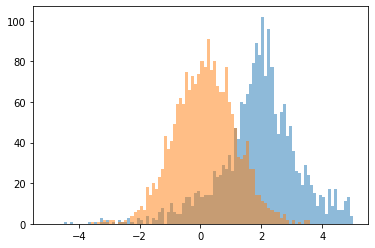

In [8]:
graphs = generate_graph_ensemble(2000, 4, 3)
#print(ensemble_statistics(graphs, 0))

feature_values = list(map(lambda graph: float(graph[0][0][0]), graphs))
#print(feature_values)

for i in range(len(graphs)):
    graphs[i][0] = diffuse_graph(graphs[i][0], 0.1, 50)

diffused_feature_values = list(map(lambda graph: float(graph[0][0][0]), graphs))

plt.hist(feature_values, 100, range = (-5, 5), alpha = 0.5)
plt.hist(diffused_feature_values, 100, range = (-5, 5), alpha = 0.5)
plt.show()